In [1]:
import torch
import lightning.pytorch as pl
from datapile import FastPMPile, HuggingfaceLoader, HuggingfaceLoader_iter
from model import Lpt2NbodyNetLightning
import yaml
import argparse
import os

def load_config(config_file):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

/home/user/ckwan1/.conda/envs/d3m/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def verify_model(model, input_shape, output_shape=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Verify that a model can successfully complete forward and backward passes.
    
    Args:
        model: The PyTorch model to verify
        input_shape: Shape of input tensor (batch size included)
        output_shape: Expected output shape (for loss calculation)
        device: Device to run verification on
    """
    model = model.to(device)
    model.train()  # Set to training mode for proper gradient computation
    
    try:
        # Create random input tensor
        dummy_input = torch.randn(*input_shape).to(device)
        dummy_input.requires_grad = True  # For models that need input gradients
        
        # Forward pass
        output = model(dummy_input)
        print("Forward pass completed successfully.")
        print(f"Output shape: {output.shape}")
        
        # Create dummy target if output_shape is provided
        if output_shape is not None:
            if isinstance(output, (list, tuple, dict)):
                # Handle multiple outputs
                dummy_target = [torch.randn(*shape).to(device) for shape in output_shape]
                loss = sum(torch.nn.functional.mse_loss(o, t) for o, t in zip(output, dummy_target))
            else:
                dummy_target = torch.randn(*output_shape).to(device)
                loss = torch.nn.functional.mse_loss(output, dummy_target)
        else:
            # Simple sum of outputs if no target shape provided
            if isinstance(output, (list, tuple, dict)):
                loss = sum(o.sum() for o in output)
            else:
                loss = output.sum()
        
        # Backward pass
        loss.backward()
        print("Backward pass completed successfully.")
        
        # Check parameter gradients
        for name, param in model.named_parameters():
            if param.grad is None:
                print(f"Warning: Parameter {name} has no gradient")
            else:
                print(f"Parameter {name} gradient norm: {param.grad.norm().item():.4f}")
        
        return True
        
    except Exception as e:
        print(f"Error during verification: {str(e)}")
        return False

In [7]:
path="/home/user/ckwan1/ml/configs/new_config/naf_denoise_coslr.yaml"
config = load_config(path)
config['model']['batch_size'] = config['data']['batch_size']
config['model']['max_epochs'] = config['trainer']['max_epochs']
config['model']['naf_middle_blk_num'] = 1
config['model']['naf_enc_blk_nums']  = [1,1]
config['model']['naf_dec_blk_nums']  = [1,1]
model = Lpt2NbodyNetLightning(**config['model'])
input_shape = (1, 3, 32, 32, 32)  
output_shape = (1, 3, 32, 32, 32)  
verify_model(model, input_shape, output_shape)

Forward pass completed successfully.
Output shape: torch.Size([1, 3, 32, 32, 32])
Backward pass completed successfully.
Parameter model.intro.weight gradient norm: 0.6609
Parameter model.intro.bias gradient norm: 0.0307
Parameter model.ending.weight gradient norm: 3.0512
Parameter model.ending.bias gradient norm: 0.0508
Parameter model.encoders.0.0.beta gradient norm: 0.0022
Parameter model.encoders.0.0.gamma gradient norm: 0.0039
Parameter model.encoders.0.0.conv1.weight gradient norm: 0.0000
Parameter model.encoders.0.0.conv1.bias gradient norm: 0.0000
Parameter model.encoders.0.0.conv2.weight gradient norm: 0.0000
Parameter model.encoders.0.0.conv2.bias gradient norm: 0.0000
Parameter model.encoders.0.0.conv3.weight gradient norm: 0.0000
Parameter model.encoders.0.0.conv3.bias gradient norm: 0.0000
Parameter model.encoders.0.0.sca.1.weight gradient norm: 0.0000
Parameter model.encoders.0.0.sca.1.bias gradient norm: 0.0000
Parameter model.encoders.0.0.conv4.weight gradient norm: 0.00

True

In [1]:
from datapile import HuggingfaceLoader
data = HuggingfaceLoader(
        dataset_path = '/home/user/ckwan1/ml/hfdataset',
        shuffle = False,
        batch_size = 1,
        num_workers = 1,
        augment = False,
        density = True,
        init_density= False
    )
data.setup("validation")
val_iter = iter(data.val_dataloader())
batch = next(val_iter)

/home/user/ckwan1/.conda/envs/d3m/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import datasets
datasets.load_from_disk(self.hparams.dataset_path)

In [2]:
batch[0].shape

torch.Size([1, 1, 32, 32, 32])

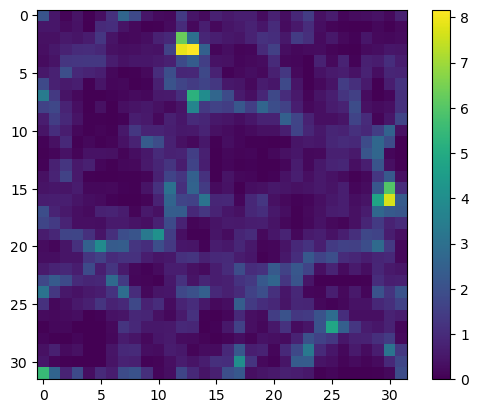

In [31]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][0,0,0])
plt.colorbar()

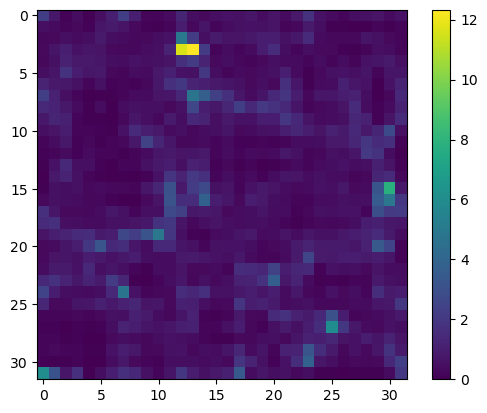

In [27]:
import matplotlib.pyplot as plt
plt.imshow(batch[1][0,0,0])
plt.colorbar()

In [4]:
import torch
import lightning.pytorch as pl
from model import Lpt2NbodyNetLightning
import yaml
file_path = '/home/user/ckwan1/ml/configs/new_config/score_model_adam_gc_reverse_init_density_individual_std1and2.yaml'
with open(file_path, 'r') as file:
    config = yaml.safe_load(file)
config['model']['batch_size'] = config['data']['batch_size']
config['model']['max_epochs'] = config['trainer']['max_epochs']
config['model']['used_density'] = config['data']['density']
config['model']['ch_mult'] = [1]
model = Lpt2NbodyNetLightning(**config['model'])

optimizer = model.configure_optimizers()
x = torch.randn(1, 1, 32, 32, 32)
y = torch.randn(1, 1, 32, 32, 32)
# Forward pass
loss = model.training_step((x,y),batch_idx=0)

# Backward pass
loss.backward()

/home/user/ckwan1/.conda/envs/d3m/lib/python3.12/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
